In [4]:
#So how can you find the principal components of a training set? Luckily, there is a 
#standard matrix factorization technique called singular value decomposition (SVD) 
#that can decompose the training set matrix X into the matrix multiplication of three 
#matrices U Σ V⊺, where V contains the unit vectors that define all the principal
#components that you are looking for, as shown in Equation 8-1.


#The following Python code uses NumPy’s svd() function to obtain all the
#principal components of the 3D training set represented in Figure 8-2, then
#it extracts the two unit vectors that define the first two PCs:

import numpy as np

X = np.arange(2,11).reshape(3,3) #small 3D dataset

X_centered = X - X.mean(axis=0)
X_centered

array([[-3., -3., -3.],
       [ 0.,  0.,  0.],
       [ 3.,  3.,  3.]])

In [7]:
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0] # PC1
c2 = Vt[1] # PC2

In [ ]:
#Projecting Down to d Dimensions

#Once you have identified all the principal components, you can reduce the
#dimensionality of the dataset down to d dimensions by projecting it onto the
#hyperplane defined by the first d principal components. Selecting this
#hyperplane ensures that the projection will preserve as much variance as
#possible. For example, in Figure 8-2 the 3D dataset is projected down to the
#2D plane defined by the first two principal components, preserving a large part of the dataset's variance.
# As a result, the 2D projection looks very much like the original 3D dataset.

#To project the training set onto the hyperplane and obtain a reduced dataset
#Xd-proj of dimensionality d, compute the matrix multiplication of the 
#training set matrix X by the matrix Wd, defined as the matrix containing the first d 
#columns of V, as shown in Equation 8-2.

#The following Python code projects the training set onto the plane defined
#by the first two principal components:

In [8]:
W2 = Vt[:2].T
X2D = X_centered @ W2

In [9]:
X2D

array([[-5.19615242e+00, -1.33226763e-15],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 5.19615242e+00,  1.33226763e-15]])

In [12]:
#There you have it! You now know how to reduce the dimensionality of any
#dataset by projecting it down to any number of dimensions, while
#preserving as much variance as possible.


#Using Scikit-Learn
#Scikit-Learn’s PCA class uses SVD to implement PCA, just like we did
#earlier in this chapter. The following code applies PCA to reduce the
#dimensionality of the dataset down to two dimensions (note that it
#automatically takes care of centering the data):


from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)


#After fitting the PCA transformer to the dataset, its components_ attribute
#holds the transpose of Wd: it contains one row for each of the first d
#principal components.


pca.components_

array([[ 0.57735027,  0.57735027,  0.57735027],
       [-0.81649658,  0.40824829,  0.40824829]])

In [13]:
#Explained Variance Ratio

#Another useful piece of information is the explained variance ratio of each
#principal component, available via the explained_variance_ratio_ variable. The 
#ratio indicates the proportion of the dataset’s variance that lies along each principal 
#component. For example, let’s look at the explained variance ratios of the first two 
#components of the 3D dataset represented in Figure 8-2:


pca.explained_variance_ratio_


array([1.00000000e+00, 4.86296734e-33])

In [16]:
#This output tells us that about 76% of the dataset’s variance lies along the first PC, 
#and about 15% lies along the second PC. This leaves about 9% for the third PC, so it 
#is reasonable to assume that the third PC probably carries little information.


#Choosing the Right Number of Dimensions
#Instead of arbitrarily choosing the number of dimensions to reduce down to, it is simpler 
#to choose the number of dimensions that add up to a sufficiently large portion of the variance—say,
#95% (An exception to this rule, of course, is if you are reducing dimensionality for data visualization,
#in which case you will want to reduce the dimensionality down to 2 or 3).


#The following code loads and splits the MNIST dataset (introduced in Chapter 3) and performs 
#PCA without reducing dimensionality, then computes the minimum number of dimensions required 
#to preserve 95% of the training set’s variance:


from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=True)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

153

In [18]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1 # since indexing starts with 0
d

154

In [23]:
#You could then set n_components=d and run PCA again, but there’s a better option. 
#Instead of specifying the number of principal components you want to preserve, 
#you can set n_components to be a float between 0.0 and 1.0, indicating the ratio of variance you wish to preserve:

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

#The actual number of components is determined during training, and it is stored in the n_components_ attribute:

pca.n_components_

154

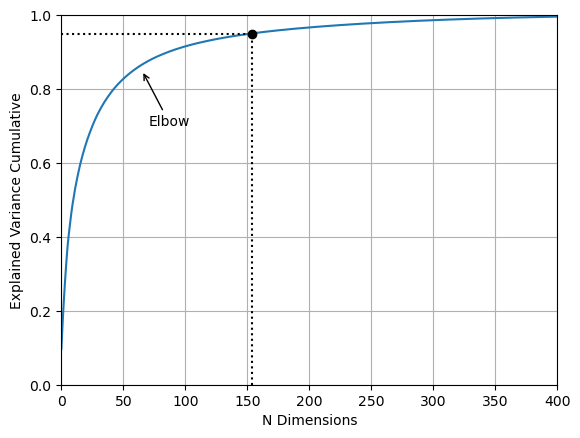

In [46]:
#Yet another option is to plot the explained variance as a function of the number 
#of dimensions (simply plot cumsum; see Figure 8-8). There will usually be an elbow 
#in the curve, where the explained variance stops growing fast. In this case, you can
#see that reducing the dimensionality down to about 100 dimensions wouldn’t lose too much explained variance.

import matplotlib.pyplot as plt

plt.plot(cumsum)
plt.grid(True)
plt.ylabel("Explained Variance Cumulative")
plt.xlabel("N Dimensions")
plt.axis([0, 400, 0, 1])
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.show()

#for straight lines:
#plot([x1, x2], [y1, y2], color='k', linestyle='-', linewidth=2)



In [31]:
#Lastly, if you are using dimensionality reduction as a preprocessing step for a supervised learning task
#(e.g., classification), then you can tune the number of dimensions as you would any other hyperparameter (see
#Chapter 2). For example, the following code example creates a two-step pipeline, first reducing 
#dimensionality using PCA, then classifying using a random forest. Next, it uses RandomizedSearchCV
#to find a good combination of hyperparameters for both PCA and the random forest classifier. This
#example does a quick search, tuning only 2 hyperparameters, training on just 1,000 instances,
#and running for just 10 iterations, but feel free to do a more thorough search if you have the time:
    
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42),
                   RandomForestClassifier(random_state=42))

param_distrib = {
        "pca__n_components": np.arange(10, 80),
        "randomforestclassifier__n_estimators": np.arange(50, 500)
}


rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3,
                               random_state=42)

rnd_search.fit(X_train[:1000], y_train[:1000])
    

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [32]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': 465, 'pca__n_components': 23}


In [48]:
#It’s interesting to note how low the optimal number of components is: we reduced a 
#784-dimensional dataset to just 23 dimensions! This is tied to the fact that we 
#used a random forest, which is a pretty powerful model. If we used a linear model 
#instead, such as an SGDClassifier, the search would find that we need to preserve more dimensions (about 70).


#PCA for Compression
#After dimensionality reduction, the training set takes up much less space. For example, after applying PCA 
#to the MNIST dataset while preserving 95% of its variance, we are left with 154 features, instead of the 
#original 784 features. So the dataset is now less than 20% of its original size, and we only lost 5% of its
#variance! This is a reasonable compression ratio, and it’s easy to see how such a size reduction would speed up
#a classification algorithm tremendously.

#It is also possible to decompress the reduced dataset back to 784 dimensions by applying the inverse
#transformation of the PCA projection. This won’t give you back the original data, since the projection
#lost a bit of information (within the 5% variance that was dropped), but it will likely be close to the
#original data. The mean squared distance between the original data and the reconstructed data (compressed
#and then decompressed) is called the reconstruction error.


#The inverse_transform() method lets us decompress the reduced MNIST dataset back to 784 dimensions:


X_recovered = pca.inverse_transform(X_reduced)


#Figure 8-9 shows a few digits from the original training set (on the left), and
#the corresponding digits after compression and decompression. You can see
#that there is a slight image quality loss, but the digits are still mostly intact.
#The equation for the inverse transformation is shown in Equation 8-3.

X_recovered

array([[ 2.64687454e-14,  2.25291411e-12,  2.21555093e-13, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.64609603e-15,  5.93995586e-13,  1.72049698e-13, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.28377776e-15,  1.12262896e-13, -2.32068544e-13, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 8.88183138e-15,  8.62393210e-13, -4.51056315e-14, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.07364675e-16, -8.21993486e-14,  4.99641520e-14, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.73667409e-15, -1.22800050e-13,  9.64210425e-14, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [49]:
#If you set the svd_solver hyperparameter to "randomized", Scikit-Learn
#uses a stochastic algorithm called randomized PCA that quickly finds an
#approximation of the first d principal components. Its computational complexity is O(m × d2) + O(d3), 
#instead of O(m × n2) + O(n3) for the full
#SVD approach, so it is dramatically faster than full SVD when d is much smaller than n:

rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)
    

In [50]:
#Incremental PCA


#One problem with the preceding implementations of PCA is that they require the whole 
#training set to fit in memory in order for the algorithm to run. Fortunately, incremental PCA
#(IPCA) algorithms have been developed that allow you to split the training set into mini-batches
#and feed these in one mini-batch at a time. This is useful for large training sets and for applying
#PCA online (i.e., on the fly, as new instances arrive).

#The following code splits the MNIST training set into 100 mini-batches (using NumPy’s array_split()
#function) and feeds them to Scikit-Learn’s IncrementalPCA class5 to reduce the dimensionality of the
#MNIST dataset down to 154 dimensions, just like before. Note that you must call the partial_fit()
#method with each mini-batch, rather than the fit() method with the whole training set:


from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)

for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

In [51]:
X_reduced = inc_pca.transform(X_train)

In [55]:
np.array_split(X_train, n_batches) #[600 rows x 784 columns] for each batch

[     pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
 0       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 1       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 2       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 3       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 4       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 ..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
 595     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 596     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 597     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 598     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 599     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 
      pixel10  ...  pixel775  pixel776

In [56]:
#For very high-dimensional datasets, PCA can be too slow. As you saw earlier, even if you use 
#randomized PCA its computational complexity is still O(m × d2) + O(d3), so the target number 
#of dimensions d must not be too large. If you are dealing with a dataset with tens of thousands
#of features or more (e.g., images), then training may become much too slow: in this case, you 
#should consider using random projection instead.


#Random Projection


#As its name suggests, the random projection algorithm projects the 
#data to a lower-dimensional space using a random linear projection.
#This may sound crazy, but it turns out that such a random projection
#is actually very likely to preserve distances fairly well, as was 
#demonstrated mathematically by William B. Johnson and Joram 
#Lindenstrauss in a famous lemma. So, two similar instances will
#remain similar after the projection, and two very different instances
#will remain very different.

#Obviously, the more dimensions you drop, the more information is lost,
#and the more distances get distorted. So how can you choose the optimal
#number of dimensions? Well, Johnson and Lindenstrauss came up with an 
#equation that determines the minimum number of dimensions to preserve
#in order to ensure—with high probability—that distances won’t change 
#by more than a given tolerance. For example, if you have a dataset 
#containing m = 5,000 instances with n = 20,000 features each, and
#you don’t want the squared distance between any two instances to 
#change by more than ε = 10%,6 then you should project the data down 
#to d dimensions, with d ≥ 4 log(m) / (1⁄2 ε2 - 1⁄3 ε3), which is 
#7,300 dimensions. That’s quite a significant dimensionality reduction!
#Notice that the equation does not use n, it only relies on m and ε.
#This equation is implemented by the johnson_lindenstrauss_min_dim()
#function:


from sklearn.random_projection import johnson_lindenstrauss_min_dim

m, ε = 5_000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps=ε)
d


7300

In [58]:
#Now we can just generate a random matrix P of shape [d, n], where 
#each item is sampled randomly from a Gaussian distribution with mean 
#0 and variance 1 / d, and use it to project a dataset from n dimensions
#down to d:


n = 20000
np.random.seed(42)
P = np.random.randn(d, n) / np.sqrt(d)

X = np.random.randn(m, n) #generate fake dataset
X_reduced = X @ P.T

#That’s all there is to it! It’s simple and efficient, and no 
#training is required: the only thing the algorithm needs to 
#create the random matrix is the dataset’s shape. The data itself 
#is not used at all.

In [60]:
P.shape

(7300, 20000)

In [62]:
#Scikit-Learn offers a GaussianRandomProjection class to do exactly
#what we just did: when you call its fit() method, it uses 
#johnson_lindenstrauss_min_dim() to determine the output 
#dimensionality, then it generates a random matrix, which it 
#stores in the components_ attribute. Then when you call transform(), 
#it uses this matrix to perform the projection. When creating the 
#transformer, you can set eps if you want to tweak ε (it defaults to 0.1)
#, and n_components if you want to force a specific target 
#dimensionality d. The following code example gives the same result 
#as the preceding code (you can also verify that 
#gaussian_rnd_proj.components_ is equal to P):

from sklearn.random_projection import GaussianRandomProjection

gaussian_rnd_proj = GaussianRandomProjection(eps=ε, random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X) #same result as above

#Scikit-Learn also provides a second random projection transformer, 
#known as SparseRandomProjection. It determines the target 
#dimensionality in the same way, generates a random matrix of the 
#same shape, and performs the projection identically. The main 
#difference is that the random matrix is sparse. This means it 
#uses much less memory: about 25 MB instead of almost 1.2 GB in
#the preceding example! And it’s also much faster, both to generate 
#the random matrix and to reduce dimensionality: about 50% faster in
#this case. Moreover, if the input is sparse, the transformation keeps
#it sparse (unless you set dense_output=True). Lastly, it enjoys the 
#same distance-preserving property as the previous approach, and the 
#quality of the dimensionality reduction is comparable. In short, 
#it’s usually preferable to use this transformer instead of the first
#one, especially for large or sparse datasets.



#If you want to perform the inverse transform, you first need to 
#compute the pseudo-inverse of the components matrix using SciPy’s
#pinv() function,then multiply the reduced data by the transpose of 
#the pseudo-inverse:

components_pinv = np.linalg.pinv(gaussian_rnd_proj.components_)
X_recovered = X_reduced @ components_pinv.T

#WARNING
#Computing the pseudo-inverse may take a very long time if the 
#components matrix is large, as the computational complexity of 
#pinv() is O(dn2) if d < n, or O(nd2) otherwise.

#In summary, random projection is a simple, fast, memory-efficient, and
#surprisingly powerful dimensionality reduction algorithm that you should
#keep in mind, especially when you deal with high-dimensional datasets.


In [64]:
#LLE
#Locally linear embedding (LLE)8 is a nonlinear dimensionality reduction
#(NLDR) technique. It is a manifold learning technique that does not 
#rely on projections, unlike PCA and random projection. In a nutshell,
#LLE works by first measuring how each training instance linearly 
#relates to its nearest neighbors, and then looking for a 
#low-dimensional representation of the training set where these 
#local relationships are best preserved (more details shortly). 
#This approach makes it particularly good at unrolling twisted manifolds,
#especially when there is not too much noise.


#The following code makes a Swiss roll, then uses Scikit-Learn’s 
#LocallyLinearEmbedding class to unroll it:
    
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10,
                            random_state=42)
X_unrolled = lle.fit_transform(X_swiss)


#The variable t is a 1D NumPy array containing the position of each
#instance along the rolled axis of the Swiss roll. We don’t use it 
#in this example, but it can be used as a target for a nonlinear 
#regression task.

#The resulting 2D dataset is shown in Figure 8-10. As you can see, 
#the Swiss roll is completely unrolled, and the distances between
#instances are locally well preserved. However, distances are not 
#preserved on a larger scale: the unrolled Swiss roll should be a 
#rectangle, not this kind of stretched and twisted band. Nevertheless,
#LLE did a pretty good job of modeling the manifold.





    